## Model Exercises - Based on Walkthrough
`Corey Solitaire`   
10.30.2020   

In [1]:
import requests
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import os
from env import host, user, password
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

## Wrangle:

In [2]:
# Call CSV
df = pd.read_csv('time_series_project.csv')
# Convert to Datetime
df.date = pd.to_datetime(df.date)
# Reset Index
df = df.set_index('date').sort_index()
df = df.dropna()

In [3]:
df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [4]:
df.tail()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-12-02,3957.0,13257.0,6.23,195.0,725.0,265.0,13.0,70.0,2305.0
2018-12-03,3660.0,12915.0,6.12,6.0,782.0,219.0,40.0,51.0,1993.0
2018-12-04,3384.0,13763.0,6.49,13.0,608.0,199.0,11.0,67.0,1663.0
2018-12-05,3670.0,13865.0,6.52,12.0,739.0,200.0,12.0,69.0,1968.0
2018-12-06,3669.0,14774.0,6.96,9.0,647.0,198.0,4.0,78.0,1962.0


In [5]:
df.shape

(225, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   calories_burned     225 non-null    float64
 1   steps               225 non-null    float64
 2   distance            225 non-null    float64
 3   floors              225 non-null    float64
 4   mins_sedentary      225 non-null    float64
 5   mins_light_active   225 non-null    float64
 6   mins_fairly_active  225 non-null    float64
 7   mins_very_active    225 non-null    float64
 8   activity_calories   225 non-null    float64
dtypes: float64(9)
memory usage: 17.6 KB


<div class="alert alert-block alert-info"><b></b></div>

# Explore:

Split:

    1. We will use the training proprtion method to split
    2. Identify lenght of df, mult by train_prop to get the number of rows. x = train_prop * 100
    3. Select row indicies
    4. Return train and test dataframes

<div class="alert alert-block alert-info"><b></b></div>

In [7]:
train_size = int(len(df)*.5)
train_size

112

In [8]:
validate_size = int(len(df)*.3)
validate_size

67

In [9]:
test_size = int(len(df) - train_size - validate_size)
test_size

46

In [10]:
# Verify all data is accounted for
validate_end_index = train_size + validate_size
validate_end_index

179

#### Use Values to Split Data Frame

In [11]:
train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

#### Verify Splits

**Does the length of each df equate to the length of the original df?**

In [12]:
print(len(train) + len(validate) + len(test) == len(df))

True


**Does the first row of original df equate to the first row of train?**


In [13]:
print(df.head(1) == train.head(1))

            calories_burned  steps  distance  floors  mins_sedentary  \
date                                                                   
2018-04-26             True   True      True    True            True   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-04-26               True                True              True   

            activity_calories  
date                           
2018-04-26               True  


**Is the last row of train the day before the first row of validate? And the same for validate to test?**

In [14]:
pd.concat([train.tail(1), validate.head(1)])

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-08-15,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0
2018-08-16,3490.0,8039.0,3.79,18.0,877.0,311.0,7.0,6.0,1678.0


In [15]:
pd.concat([validate.tail(1), test.head(1)])

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-10-21,3991.0,16642.0,7.85,15.0,437.0,349.0,33.0,58.0,2485.0
2018-10-22,3149.0,8328.0,3.93,7.0,747.0,172.0,4.0,28.0,1239.0


**Is the last row of test the same as the last row of our original dataframe?**

In [16]:
pd.concat([test.tail(1), df.tail(1)])

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-12-06,3669.0,14774.0,6.96,9.0,647.0,198.0,4.0,78.0,1962.0
2018-12-06,3669.0,14774.0,6.96,9.0,647.0,198.0,4.0,78.0,1962.0


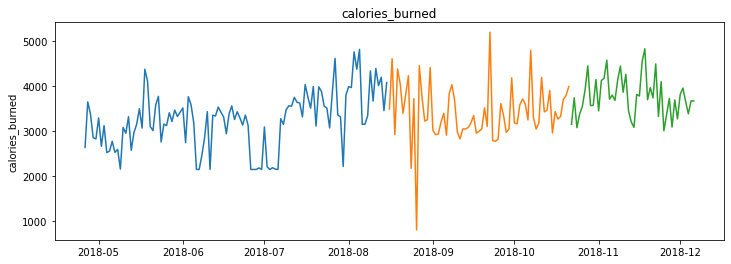

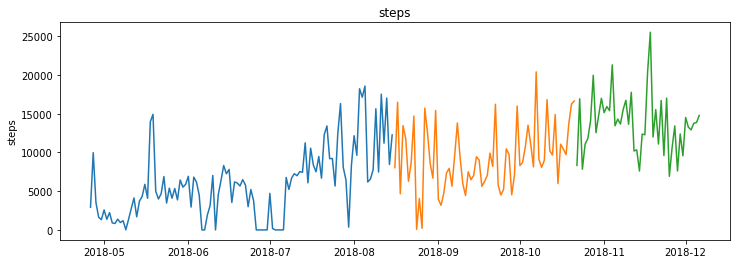

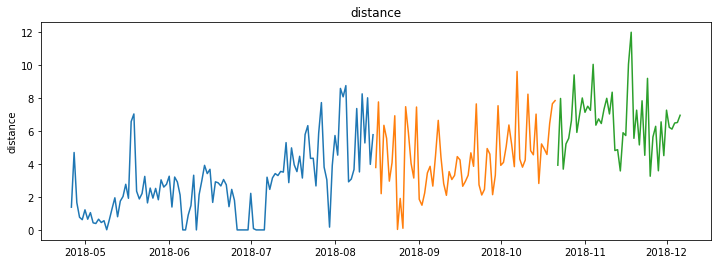

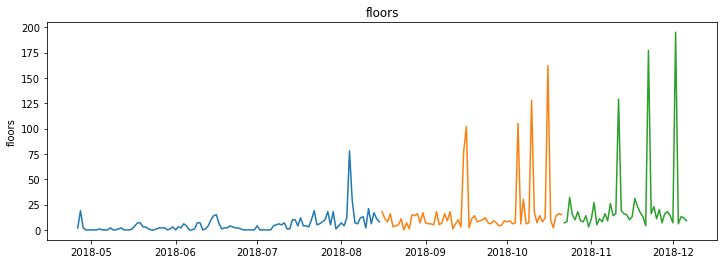

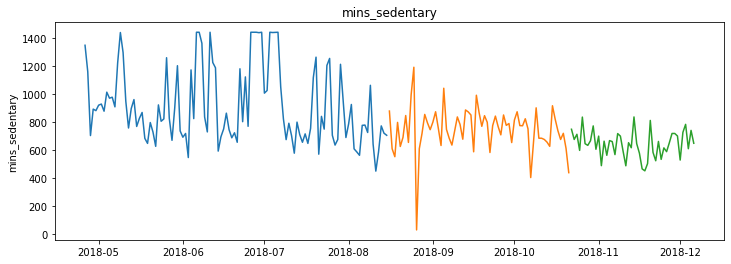

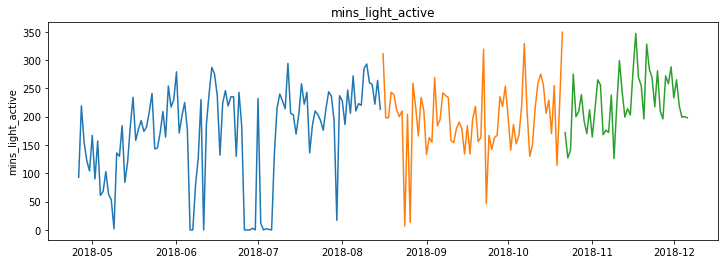

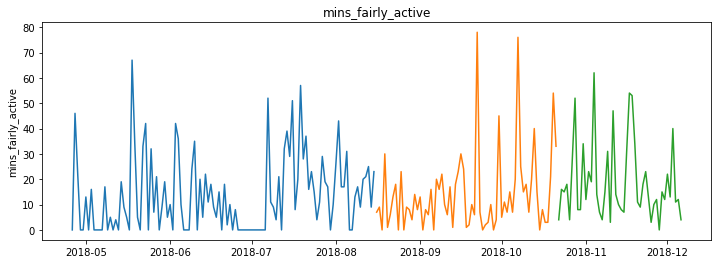

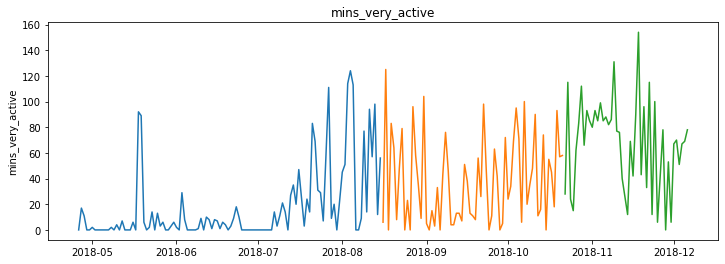

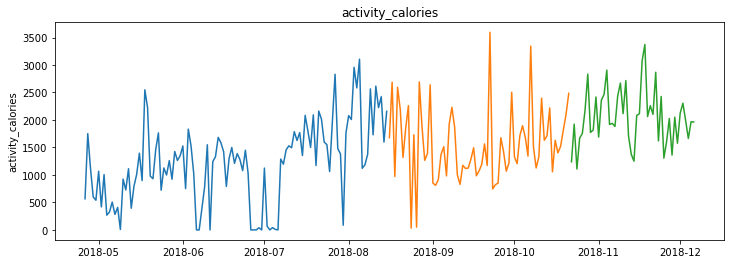

In [17]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

#### Create Evaluate Functions

In [18]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [19]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [20]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [21]:
# Verify Functions Work Properly
eval_df

,model_type,target_var,rmse


<div class="alert alert-block alert-info"><b></b></div>

# Forecast

Forecasting is another word for predicting time series data.

    Last Observed Value
    Simple Average
    Moving Average
    Holt's Linear Trend
    Previous Cycle

<div class="alert alert-block alert-info"><b></b></div>

## Last Observed Value

<div class="alert alert-block alert-info"><b></b></div>

In [22]:
list = list(train.columns)
list

['calories_burned',
 'steps',
 'distance',
 'floors',
 'mins_sedentary',
 'mins_light_active',
 'mins_fairly_active',
 'mins_very_active',
 'activity_calories']

#### Make Predictions

In [23]:
# calories_burned Prediction
calories_burned  = round(train['calories_burned'][-1:][0], 2)
# steps prediction
steps = round(train['steps'][-1:][0], 2)
# distance prediction
distance = round(train['distance'][-1:][0], 2)
# floors prediction
floors = round(train['floors'][-1:][0], 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'][-1:][0], 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'][-1:][0], 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'][-1:][0], 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'][-1:][0], 2)
# activity_calories
activity_calories = round(train['activity_calories'][-1:][0], 2)

#### Apply Predictions to Observations

In [24]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-08-16,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0
2018-08-17,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0
2018-08-18,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0
2018-08-19,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0
2018-08-20,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0


#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 921


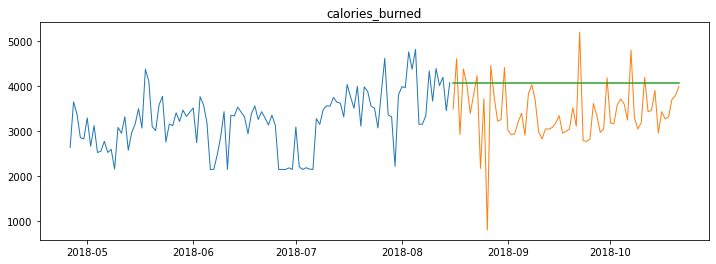

steps -- RMSE: 5156


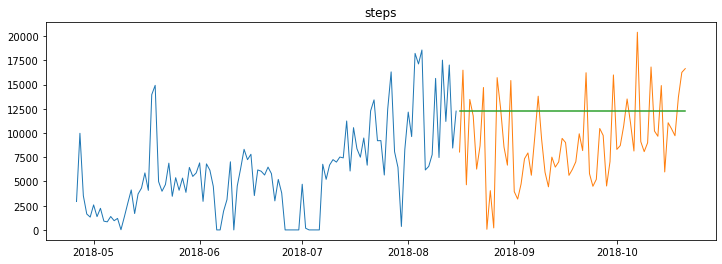

distance -- RMSE: 2


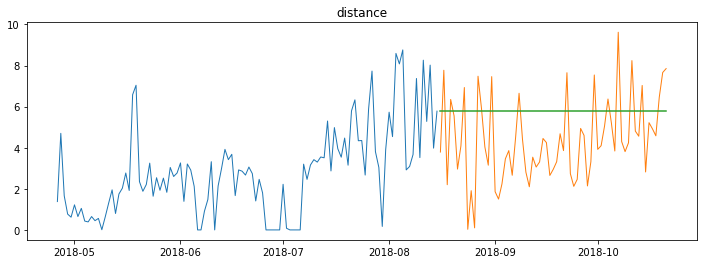

floors -- RMSE: 31


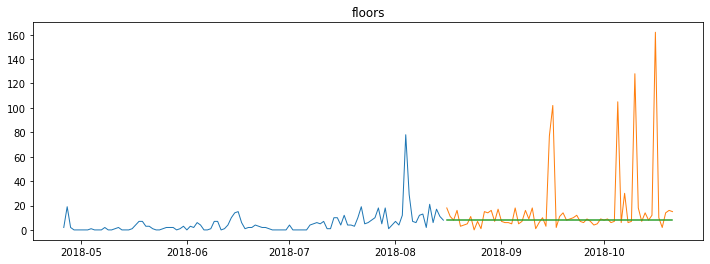

mins_sedentary -- RMSE: 163


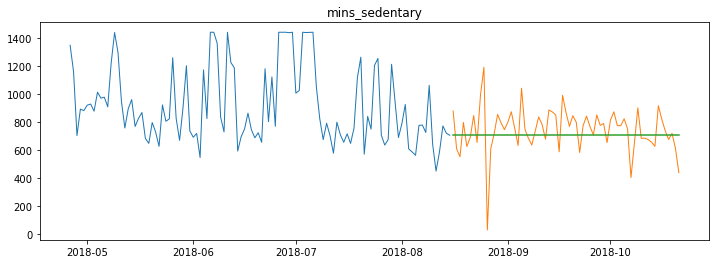

mins_light_active -- RMSE: 64


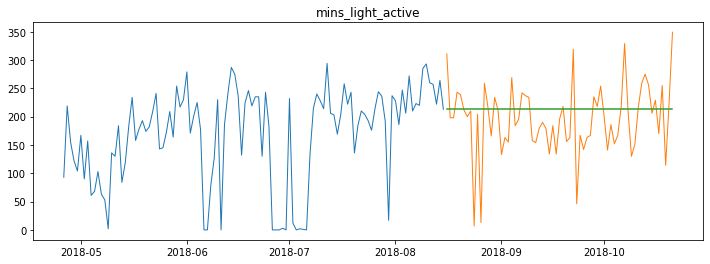

mins_fairly_active -- RMSE: 18


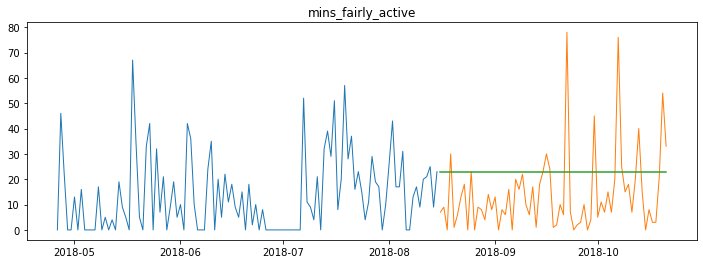

mins_very_active -- RMSE: 38


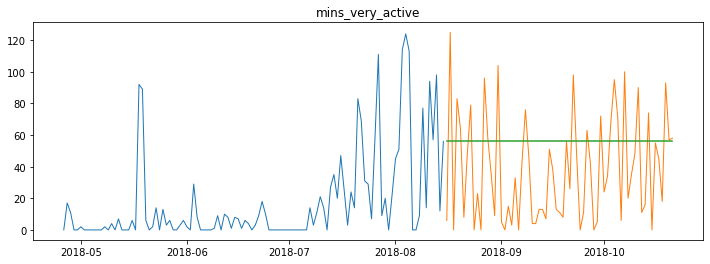

activity_calories -- RMSE: 897


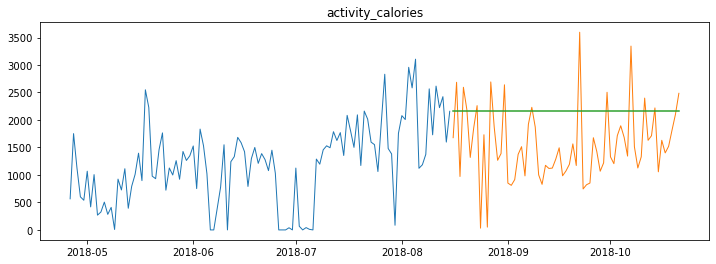

In [25]:
# Use Function to loop through columns
for col in train.columns:
    plot_and_eval(col)

#### Evauate

In [26]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,calories_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,distance,2.0
3,last_observed_value,floors,31.0
4,last_observed_value,mins_sedentary,163.0
5,last_observed_value,mins_light_active,64.0
6,last_observed_value,mins_fairly_active,18.0
7,last_observed_value,mins_very_active,38.0
8,last_observed_value,activity_calories,897.0


***

**Takeaway:**

`The last vale in Train just happened to be a day where this individual stopped their regular pattern of behavior.  RMSE is very hight, average line is far from validate, model demonstrate low perdictive value`

***

<div class="alert alert-block alert-info"><b></b></div>

## Simple Average

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions

In [27]:
# calories_burned Prediction
calories_burned  = round(train['calories_burned'].mean(), 2)
# steps prediction
steps = round(train['steps'].mean(), 2)
# distance prediction
distance = round(train['distance'].mean(), 2)
# floors prediction
floors = round(train['floors'].mean(), 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'].mean(), 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'].mean(), 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'].mean(), 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'].mean(), 2)
# activity_calories
activity_calories = round(train['activity_calories'].mean(), 2)

#### Apply Predictions to Observations

In [28]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-08-16,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98
2018-08-17,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98
2018-08-18,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98
2018-08-19,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98
2018-08-20,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98


#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 658


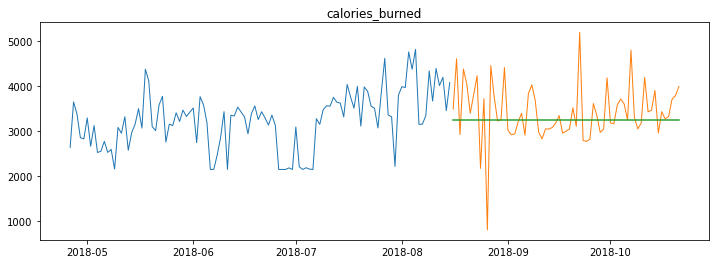

steps -- RMSE: 5356


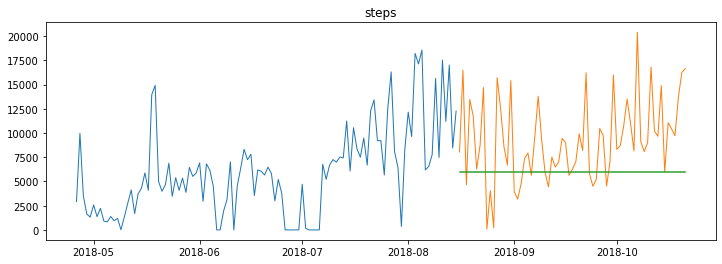

distance -- RMSE: 3


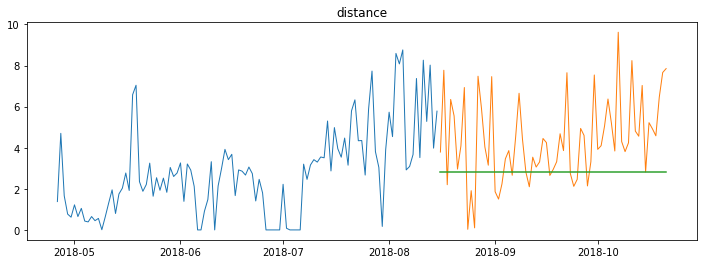

floors -- RMSE: 32


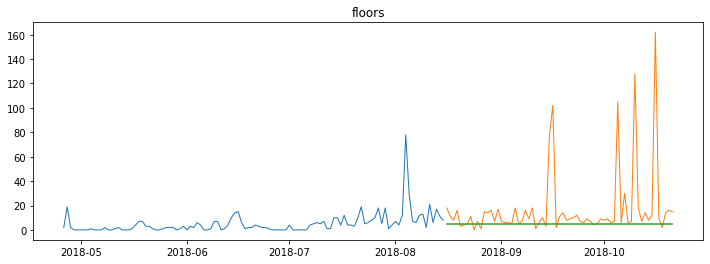

mins_sedentary -- RMSE: 233


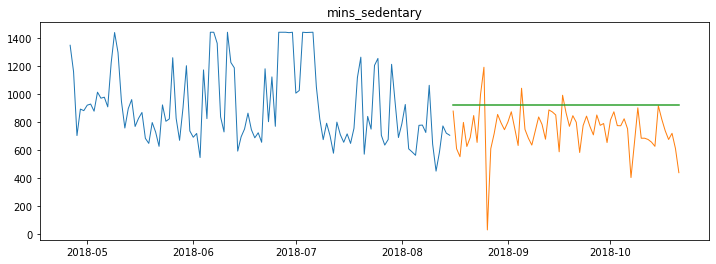

mins_light_active -- RMSE: 68


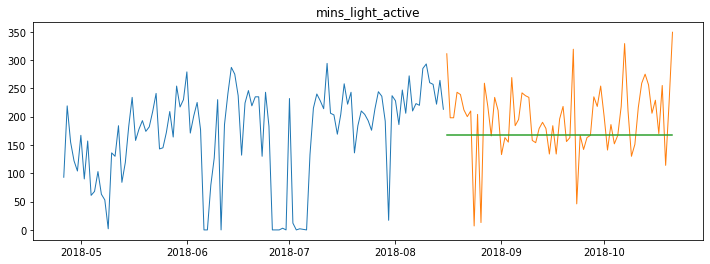

mins_fairly_active -- RMSE: 16


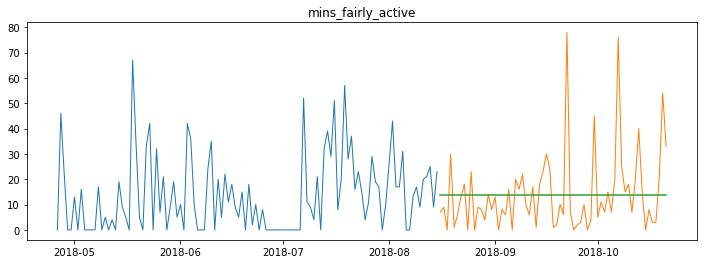

mins_very_active -- RMSE: 39


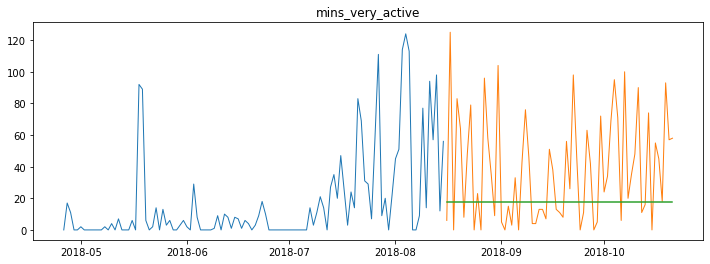

activity_calories -- RMSE: 746


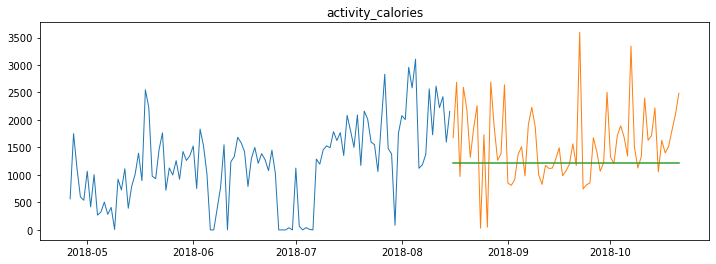

In [29]:
# Use Function to loop through columns
for col in train.columns:
    plot_and_eval(col)

#### Evauate

In [30]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df.sort_values('rmse')

,model_type,target_var,rmse
2,last_observed_value,distance,2.0
11,simple_average,distance,3.0
15,simple_average,mins_fairly_active,16.0
6,last_observed_value,mins_fairly_active,18.0
3,last_observed_value,floors,31.0
12,simple_average,floors,32.0
7,last_observed_value,mins_very_active,38.0
16,simple_average,mins_very_active,39.0
5,last_observed_value,mins_light_active,64.0
14,simple_average,mins_light_active,68.0


***

**Takeaway:**

`Simple average has lower RMSE than last observed value. This model has the best perdictive value so far`

***

<div class="alert alert-block alert-info"><b></b></div>

## Moving Average

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions

In [31]:
# 30 Day Rolling average (notice monthly seasonality)

period = 30 

# calories_burned Prediction
calories_burned  = round(train['calories_burned'].rolling(period).mean()[-1], 2)
# steps prediction
steps = round(train['steps'].rolling(period).mean()[-1], 2)
# distance prediction
distance = round(train['distance'].rolling(period).mean()[-1], 2)
# floors prediction
floors = round(train['floors'].rolling(period).mean()[-1], 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'].rolling(period).mean()[-1], 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'].rolling(period).mean()[-1], 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'].rolling(period).mean()[-1], 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'].rolling(period).mean()[-1], 2)
# activity_calories
activity_calories = round(train['activity_calories'].rolling(period).mean()[-1], 2)

#### Apply Predictions to Observations

In [32]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-08-16,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-17,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-18,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-19,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-20,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93


#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 732


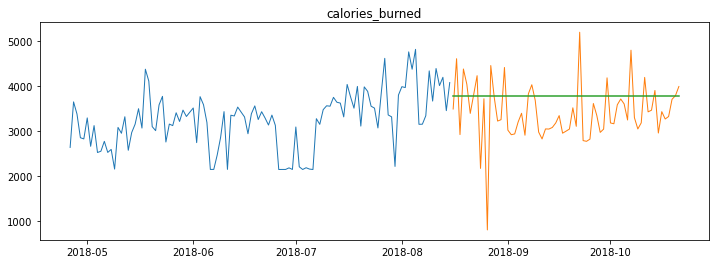

steps -- RMSE: 4425


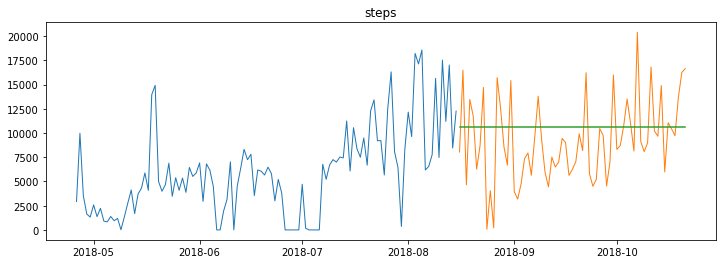

distance -- RMSE: 2


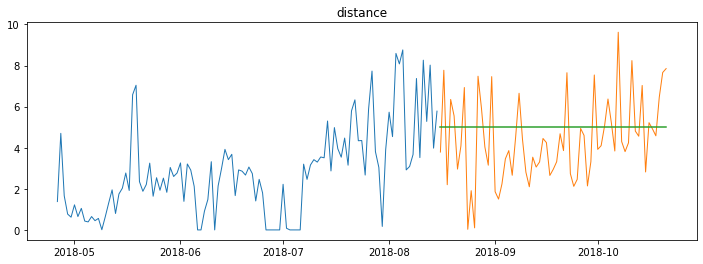

floors -- RMSE: 30


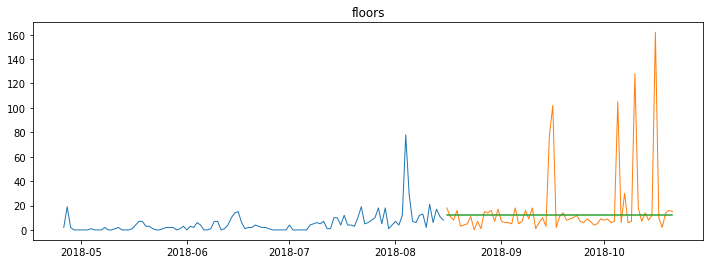

mins_sedentary -- RMSE: 166


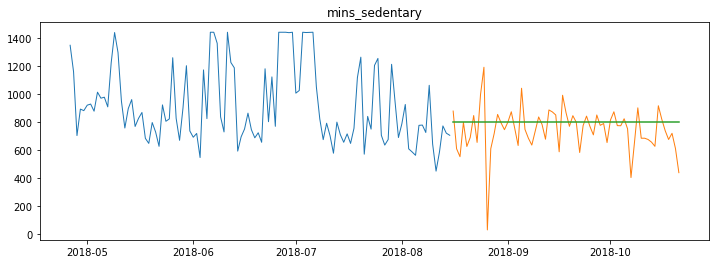

mins_light_active -- RMSE: 66


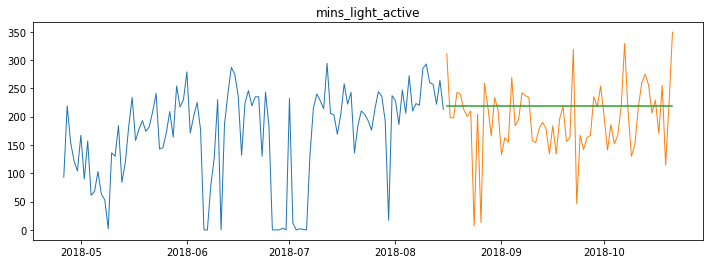

mins_fairly_active -- RMSE: 16


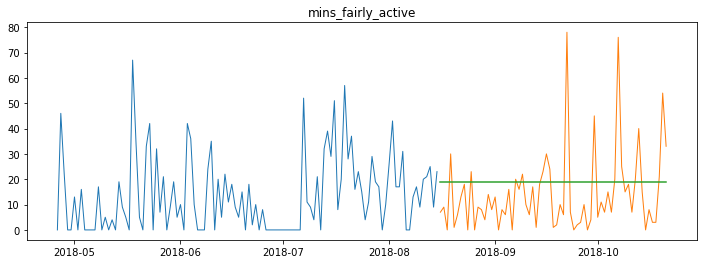

mins_very_active -- RMSE: 34


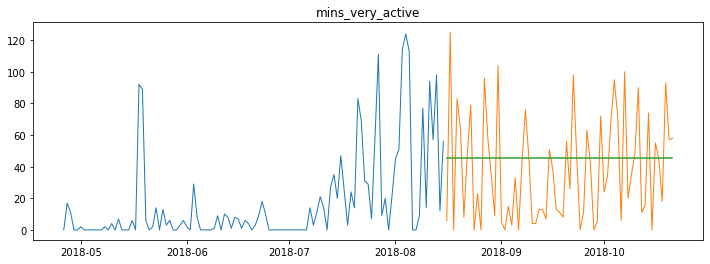

activity_calories -- RMSE: 736


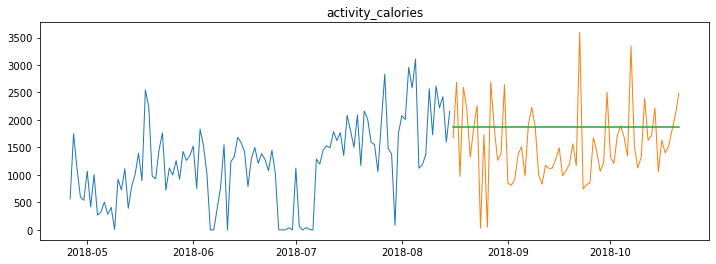

In [33]:
for col in train.columns:
    plot_and_eval(col)

#### Evauate

In [34]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df.sort_values('rmse')

,model_type,target_var,rmse
20,30d_moving_avg,distance,2.0
2,last_observed_value,distance,2.0
11,simple_average,distance,3.0
24,30d_moving_avg,mins_fairly_active,16.0
15,simple_average,mins_fairly_active,16.0
6,last_observed_value,mins_fairly_active,18.0
21,30d_moving_avg,floors,30.0
3,last_observed_value,floors,31.0
12,simple_average,floors,32.0
25,30d_moving_avg,mins_very_active,34.0


***

**Takeaway:**

`30 Day moving average has lower RMSE than simple average. This model has the best perdictive value so far`

***

<div class="alert alert-block alert-info"><b></b></div>

## Holt's Linear Trend

<div class="alert alert-block alert-info"><b></b></div>


#### Seasonal Decomposition

`First, let's take a look at the seasonal decomposition for each target.`


In [35]:
# for col in train.columns:
#     print(col, '\n')
#     sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
#     plt.show()

#### Make Predictions

In [36]:

# for col in train.columns:
#     model = Holt(train[col], exponential=False, damped=True)
#     model = model.fit(optimized=True)
#     yhat_items = model.predict(start = validate.index[0],
#                                end = validate.index[-1])
#     yhat_df[col] = round(yhat_items, 2)

#### Apply Predictions to Observations

#### Plot Actual Vs. Predicted Values

#### Evauate

<div class="alert alert-block alert-info"><b></b></div>

## Previous Cycle

<div class="alert alert-block alert-info"><b></b></div>

In [37]:
df.index.unique()

DatetimeIndex(['2018-04-26', '2018-04-27', '2018-04-28', '2018-04-29',
               '2018-04-30', '2018-05-01', '2018-05-02', '2018-05-03',
               '2018-05-04', '2018-05-05',
               ...
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06'],
              dtype='datetime64[ns]', name='date', length=225, freq=None)

#### Make Predictions

In [38]:
train = df[:'2018-11-22']
validate = df.loc['2018-11-23':'2018-11-29']
test = df.loc['2018-11-30':'2018-12-06']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(211, 9)
(7, 9)
(7, 9)


,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [40]:
train.tail(1)

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-11-22,4494.0,16705.0,7.84,177.0,522.0,284.0,18.0,115.0,2868.0


#### Apply Predictions to Observations

In [44]:
yhat_df = train.loc[:'2018-11-22'] + train.diff(7).mean()

In [45]:
pd.concat([yhat_df.head(1), validate.head(1)])

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2673.058824,3372.955882,1.588922,3.25,1332.696078,97.95098,0.632353,2.661765,623.764706
2018-11-23,3325.000000,9602.000000,4.530000,16.00,660.000000,269.00000,23.000000,12.000000,1619.000000


#### Plot Actual Vs. Predicted Values

ValueError: Found input variables with inconsistent numbers of samples: [7, 211]

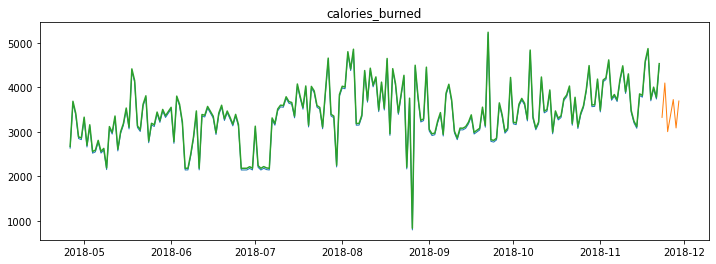

In [46]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_cycle", 
                            target_var = col)

#### Evauate

<div class="alert alert-block alert-info"><b></b></div>